In [2]:
import pandas as pd
from time import time
import requests
from bs4 import BeautifulSoup
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.utils import simple_preprocess
import re
from ast import literal_eval
from collections import namedtuple, Counter
from sklearn.manifold import TSNE
tsne=TSNE()


from sklearn.cluster import DBSCAN
dbscan=DBSCAN()

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import numpy as np
import random
import json
from titlecase import titlecase
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\ionab\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
with open('../creds.json') as f:
    creds = json.load(f)

plotly.tools.set_credentials_file(username='ionab10', api_key=creds['Plotly'])

# Cleaning

## Load Dataset

In [4]:
song_df=pd.read_csv("../Data/songdata_scraped.csv",sep=',', encoding='utf-8')
song_df.set_index('Unnamed: 0',inplace=True)
song_df.sort_index(inplace=True)
song_df.drop(['Unnamed: 0.1'], axis=1, inplace=True)
print(len(song_df))
song_df.head()

56550


,language,artist,link,song,lyrics,release_date,album,genre
Unnamed: 0,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop


### Columns

Artist: The artist's name.
<br>
Album: The album title.
<br>
Release date: The year the song was released.
<br>
Lyrics: The plain-text lyrics for the song.
<br>
Language: The primary language of the lyrics.
<br>
Genre: The category of musical composition characterized by a particular style, form, or content. 

https://www.merriam-webster.com/dictionary/genre

### Validating datatypes
The song name, artist, lyrics, album and genre should all be strings, while the release_date should be an integer.

In [5]:
for col in song_df.columns:
    print(col, '\t', Counter([type(x) for x in song_df[col]]))

language 	 Counter({<class 'float'>: 42169, <class 'str'>: 14381})
artist 	 Counter({<class 'str'>: 56550})
link 	 Counter({<class 'str'>: 56550})
song 	 Counter({<class 'str'>: 56550})
lyrics 	 Counter({<class 'str'>: 56550})
release_date 	 Counter({<class 'numpy.float64'>: 56550})
album 	 Counter({<class 'str'>: 32833, <class 'float'>: 23717})
genre 	 Counter({<class 'str'>: 36423, <class 'float'>: 20127})


Genre and album names were scraped for about two thirds of the dataset. Which explains the float (nan) values. Since the lyrics are the primary feature of the dataset, and the other features are only used for exploratory analysis and validation, we will accept a large proportion of missing values as we will assume they are randomly distributed. 

### Summary Statistics

In [6]:
for col in ['artist', 'genre','album']:
    counter=Counter(song_df[col])
    n_obs=len(song_df)
    missing=song_df[col].isnull().sum()
    
    print(col)
    print('# Observations (not incl. missing):',n_obs-missing)
    print('# Missing values:',missing, '\t% Missing values: {}%'.format(round(missing/n_obs*100,3)))
    print('Mode:', counter.most_common(1)[0][0], '\t\tMode %:', round(counter.most_common(1)[0][1]/n_obs*100,3))
    try:
        print('2nd Mode:', counter.most_common(2)[1][0], '\t\t2nd Mode %:', round(counter.most_common(2)[1][1]/n_obs*100,3))
    except:
        print('No 2nd Mode')
    print('Distinct values:', len(counter))
        
    print(counter.most_common(12))
    print('\n')
    

artist
# Observations (not incl. missing): 56550
# Missing values: 0 	% Missing values: 0.0%
Mode: Bon Jovi 		Mode %: 0.446
2nd Mode: Bob Dylan 		2nd Mode %: 0.433
Distinct values: 643
[('Bon Jovi', 252), ('Bob Dylan', 245), ('Bing Crosby', 216), ('Bob Seger', 202), ('Black Sabbath', 192), ('Donna Summer', 191), ('Blur', 190), ('Alabama', 187), ('Cher', 187), ('Loretta Lynn', 187), ('Reba Mcentire', 187), ('Chaka Khan', 186)]


genre
# Observations (not incl. missing): 36423
# Missing values: 20127 	% Missing values: 35.592%
Mode: nan 		Mode %: 35.592
2nd Mode: Pop 		2nd Mode %: 26.083
Distinct values: 18
[(nan, 20127), ('Pop', 14750), ('Rock', 10165), ('Other', 2175), ('Country', 2169), ('R&B', 1525), ('Hip-Hop/Rap', 1453), ('Metal', 1202), ('Folk', 706), ('Gospel', 456), ('Punk', 437), ('Jazz', 416)]


album
# Observations (not incl. missing): 32833
# Missing values: 23717 	% Missing values: 41.94%
Mode: nan 		Mode %: 41.94
2nd Mode: Unreleased 		2nd Mode %: 0.106
Distinct values: 73

In [7]:
col='release_date'
n_obs=len(song_df)
missing=song_df[col].isnull().sum()
print(col)
print('# Observations (not incl. missing):',n_obs-missing)
print('# Missing values:',missing, '\t% Missing values: {}%'.format(round(missing/n_obs*100,3)))
song_df.release_date.describe()

release_date
# Observations (not incl. missing): 28314
# Missing values: 28236 	% Missing values: 49.931%


count    28314.000000
mean      1992.838101
std         13.899440
min       1929.000000
25%       1982.000000
50%       1995.000000
75%       2004.000000
max       2018.000000
Name: release_date, dtype: float64

## Duplicates
We will consider song title and artist as uniquely identifying features of a song and therefore remove duplicates based on these columns.

In [8]:
song_df.drop_duplicates(subset=['song', 'artist'],inplace=True)
len(song_df)

56148

## Derived Variables 
* Song length: (number of words)

In [9]:
song_df['song_length']=[len(lyrics.split()) for lyrics in song_df.lyrics]

song_df.head()

,language,artist,link,song,lyrics,release_date,album,genre,song_length
Unnamed: 0,,,,,,,,,
0,NaN,ABBA,/a/abba/shes+my+kind+of+girl_20598417.html,She's My Kind Of Girl,"Look at her face, it's a wonderful face \r\r\...",1973.0,Ring Ring,Pop,153
1,NaN,ABBA,/a/abba/andante+andante_20002708.html,"Andante, Andante","Take it easy with me, please \r\r\r\r\r\r\r\r...",NaN,NaN,NaN,260
2,NaN,ABBA,/a/abba/as+good+as+new_20003033.html,As Good As New,I'll never know why I had to go \r\r\r\r\r\r\...,NaN,NaN,NaN,312
3,NaN,ABBA,/a/abba/bang_20598415.html,Bang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,200
4,NaN,ABBA,/a/abba/bang+a+boomerang_20002668.html,Bang-A-Boomerang,Making somebody happy is a question of give an...,1975.0,ABBA,Pop,198


## Distributions

### Song length

count    56148.000000
mean       219.962011
std        109.174001
min         37.000000
25%        145.000000
50%        196.000000
75%        264.000000
max        827.000000
Name: song_length, dtype: float64

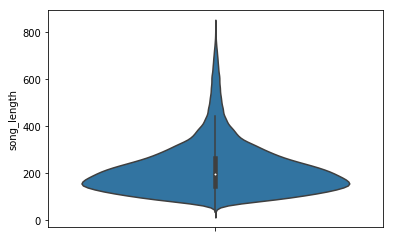

In [10]:
sns.violinplot(y='song_length', data=song_df)
song_df['song_length'].describe()

Most songs don't have at most a few hundred words although we do see some quite long/"wordy" songs.

### Artists
Here, we are checking to see if we have a wide variety of artists. Since there are too many artists to consider individually, we look at the distribution of first letters.

In [11]:
artists=sorted(list(set(song_df.artist)))
Counter([a[0] for a in artists])

Counter({"'": 1,
         'A': 25,
         'B': 27,
         'C': 29,
         'D': 28,
         'E': 28,
         'F': 25,
         'G': 25,
         'H': 20,
         'I': 25,
         'J': 28,
         'K': 24,
         'L': 26,
         'M': 28,
         'N': 24,
         'O': 24,
         'P': 29,
         'Q': 16,
         'R': 27,
         'S': 28,
         'T': 31,
         'U': 23,
         'V': 19,
         'W': 27,
         'X': 13,
         'Y': 24,
         'Z': 19})

### Year

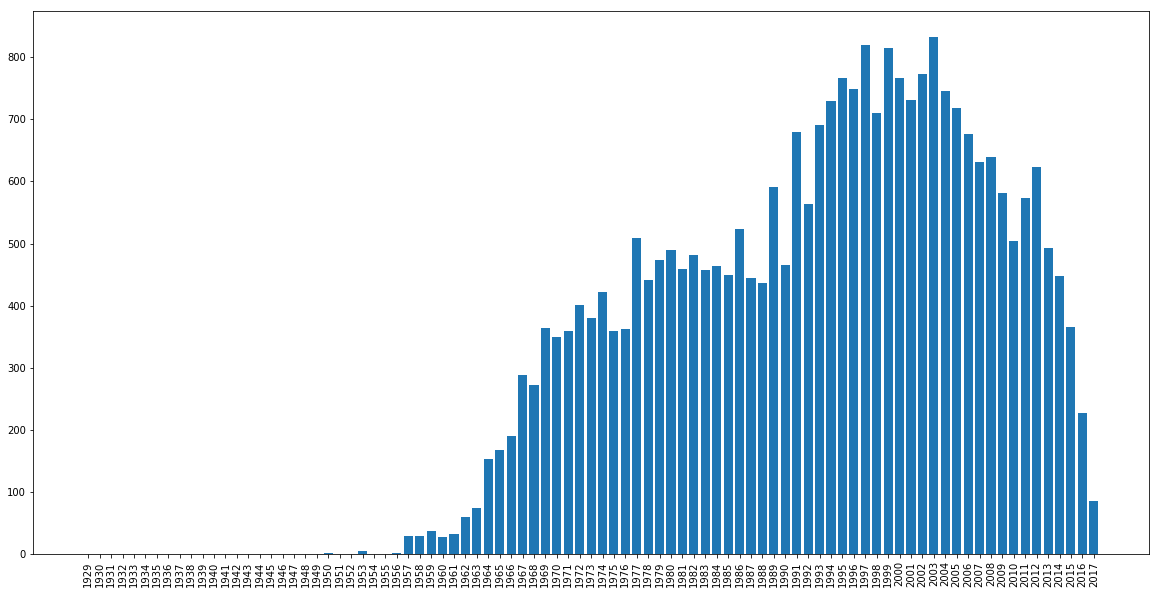

In [12]:
plt.subplots(figsize=(20,10))
temp=song_df.release_date.dropna().astype(int)
counter=Counter(temp)
idx=range(max(temp)-min(temp))
plt.bar(idx, [counter[i] if i in counter.keys() else 0 for i in range(min(temp),max(temp))])
plt.xticks(idx, range(min(temp),max(temp)), rotation=90)
plt.show()

The sampling across the release dates was not very uniform so we shall just take that into account as needed.

In [16]:
temp.quantile(0.1)

1972.0

### Genre
Let's look at the distribution of genres in our dataset. We expect there to be a large amount of Pop and Rock as these are large genres of which many other genres are considered subsets of.

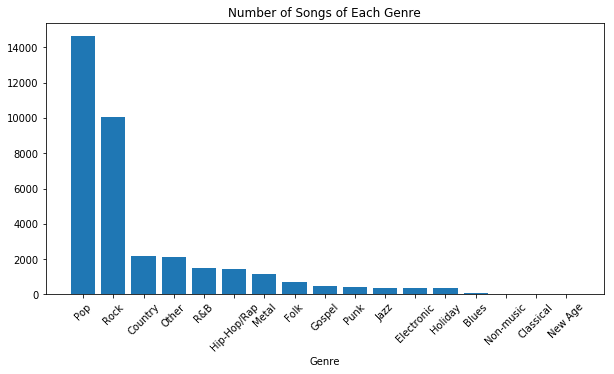

In [24]:
plt.subplots(figsize=(10,5))
temp=song_df.genre.dropna()
counter=sorted(Counter(temp).items(), key=lambda x: x[1], reverse=True)
plt.bar(np.arange(len(counter)), [x[1] for x in counter])
plt.xticks(np.arange(len(counter)), [x[0] for x in counter], rotation=45)
plt.title('Number of Songs of Each Genre')
plt.xlabel('Genre')
plt.savefig('../Figures/genre_count.pdf')
plt.show()

For example, Electronic is often considered a sub-genre of Pop. This means that many songs that were simply tagged 'Pop' may in fact be electronic. This makes genre tagging tricky because there is not really a hard line between some of these genres.

### Artist vs Genre

In [25]:
genres_per_artist=song_df.loc[:,['artist','genre']].groupby('artist').nunique()['genre']
Counter(genres_per_artist)

Counter({0: 38, 1: 83, 2: 167, 3: 154, 4: 109, 5: 60, 6: 14, 7: 9, 8: 4, 9: 5})

In [39]:
temp=list(genres_per_artist.sort_values(ascending=False)[:10].index)
song_df[song_df['artist'].isin(temp)].loc[:,['artist','genre']].groupby('artist').agg({'genre': lambda x: set(x)})

,genre
artist,
Bob Dylan,"{nan, Country, Other, Jazz, Pop, Holiday, Rock..."
Cyndi Lauper,"{nan, Other, Jazz, Electronic, Hip-Hop/Rap, Po..."
Donna Summer,"{nan, Other, Jazz, Electronic, Pop, Holiday, B..."
Johnny Cash,"{nan, Country, Jazz, Pop, Holiday, Rock, Blues..."
Leonard Cohen,"{nan, Other, Country, Electronic, Pop, Rock, B..."
Linda Ronstadt,"{nan, Country, Other, Jazz, Pop, Holiday, Rock..."
Nat King Cole,"{nan, Country, Jazz, Other, Classical, Pop, Ho..."
Nina Simone,"{nan, Other, Jazz, Hip-Hop/Rap, Pop, Rock, Non..."
Perry Como,"{nan, Other, Jazz, Classical, Hip-Hop/Rap, Pop..."


In general, each artist specialises in only a few genres (some genres may overlap). However, artists such as Bob Dylan have been known to sing many genres.

### Song length vs genre


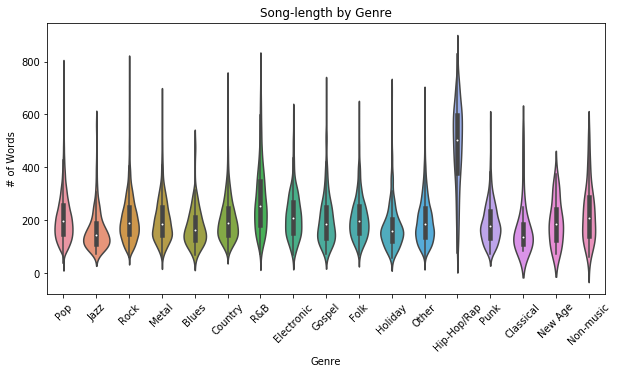

In [40]:
plt.subplots(figsize=(10,5))
sns.violinplot('genre','song_length', data=song_df)
plt.xticks(rotation=45)
plt.title('Song-length by Genre')
plt.xlabel('Genre')
plt.ylabel('# of Words')
plt.savefig('../Figures/wordcount_bygenre.pdf')

Hip-hop/rap songs tend to have more words because the singers speak faster.

## Save as new csv

In [41]:
song_df.to_csv('../Data/songdata_clean.csv',sep=',', encoding='utf-8' )